# This notebook is for the autosklearn hyperparameter optimization

## Imports

### Basic imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [5]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

## Functions for storing the data

In [6]:
def pickle_dump(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)

def pickle_load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

## Running the autosklearn classifiers on varying minutes

In [ ]:
fl = "winequality-white.csv"
table = pd.read_csv(fl, delimiter = ";", header='infer')

# We are aiming to predict quality with the features chosen from the correlations
features = ["alcohol", "density", "chlorides", "volatile acidity", "total sulfur dioxide", "fixed acidity", "pH"]
X = table[features]
y = table.quality


minutes_run = [1, 5, 15, 30, 60]
for minutes in minutes_run:
    automl = autosklearn.classification.AutoSklearnClassifier(
            include = {
                # Classifiers
                'classifier': ["decision_tree", "random_forest", "gradient_boosting", "liblinear_svc", "k_nearest_neighbors"],
                'feature_preprocessor': ["no_preprocessing"],
            },
            # Inner cross validation
            resampling_strategy="cv",
            resampling_strategy_arguments={"folds":5},

            time_left_for_this_task=60*minutes,
            tmp_folder=None,
            memory_limit=None,
            seed=3,
            initial_configurations_via_metalearning=0,

            n_jobs = 3,

            metric=autosklearn.metrics.accuracy,
        )
    # Run the automl model
    automl.fit(X,y)
    
    # Store results
    fname = f'./minutes_run/cv_results_{minutes}_minutes.pkl'
    pickle_dump(automl.cv_results_, fname)

    print(f'Minute {minutes} is done')

## Functions for Plotting

In [70]:
def get_total_accuracy_boxplot(minutes_run):
    table = {}
    j = 0
    for minutes in minutes_run:
        fname = f'./minutes_run/cv_results_{minutes}_minutes.pkl'
        automl_results = pickle_load(fname)
        for i, run_info in enumerate(automl_results['params']):
            row = {}
            row['Classifier'] = run_info['classifier:__choice__']
            row['Accuracy'] = automl_results['mean_test_score'][i]
            row['Minutes'] = minutes
            table[j] = row
            j+=1
    tab = pd.DataFrame.from_dict(table).T
    # Removing crashed or unfinished runs
    return tab.loc[tab['Accuracy'] > 0]


def boxplot_automl_all_minutes_run():
    minutes_run = [1, 5, 15, 30, 60]
    table = get_total_accuracy_boxplot(minutes_run)

    fig, axs = plt.subplots(1,5, sharey='all')
    fig.suptitle('Accuracy Results')
    fig.supylabel('Accuracy')
    for i, minute in enumerate(minutes_run):
        sub_table = table[table['Minutes'] == minute]

        sns.boxplot(ax= axs[i], x=sub_table['Minutes'], y = sub_table['Accuracy'], hue = sub_table['Classifier'] )\
                    .set(ylabel = None)
        axs[i].legend([], [], frameon=False)
        
    lines, labels = axs[0].get_legend_handles_labels()

    # Finally, the legend (that maybe you'll customize differently)
    fig.legend(lines, labels, loc=(0.01,0.90), ncol=5)

    
    # sns.set(rc={'figure.figsize':(10,10)})
    plt.savefig("figures/box_plot_autosklearn")  
    return 

## Boxplot the results

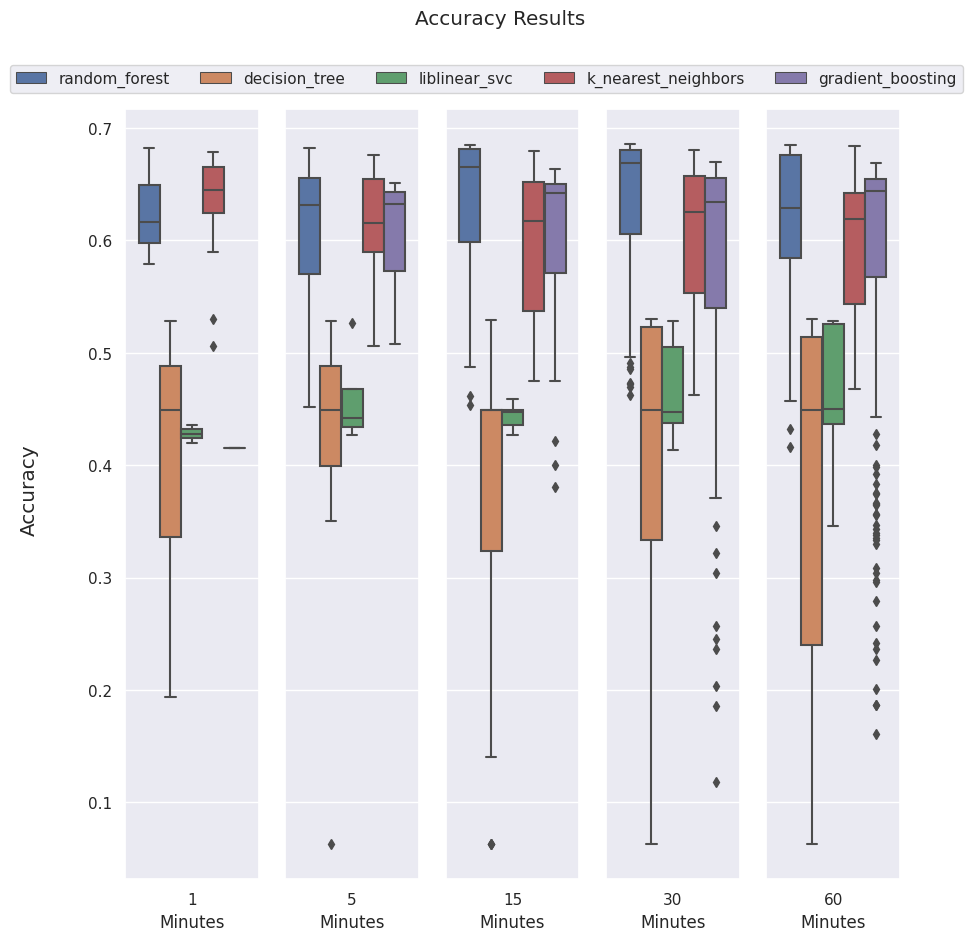

In [71]:
boxplot_automl_all_minutes_run()

## Get hyperparameters for best function

In [7]:
def get_best_scores_hyperparameters(automl_results):
    i = np.argmin(automl_results['rank_test_scores'])
    accuracy_score = automl_results['mean_test_score'][i]
    new_dict = automl_results['params'][i]
    new_dict['accuracy'] = accuracy_score
    return new_dict

## Get the best hyperparameters of the best function from 60 minutes

In [23]:
fname = './minutes_run/cv_results_60_minutes.pkl'
get_best_scores_hyperparameters(pickle_load(fname))

{'balancing:strategy': 'weighting',
 'classifier:__choice__': 'random_forest',
 'data_preprocessor:__choice__': 'feature_type',
 'feature_preprocessor:__choice__': 'no_preprocessing',
 'classifier:random_forest:bootstrap': 'True',
 'classifier:random_forest:criterion': 'gini',
 'classifier:random_forest:max_depth': 'None',
 'classifier:random_forest:max_features': 0.02251148349613017,
 'classifier:random_forest:max_leaf_nodes': 'None',
 'classifier:random_forest:min_impurity_decrease': 0.0,
 'classifier:random_forest:min_samples_leaf': 1,
 'classifier:random_forest:min_samples_split': 3,
 'classifier:random_forest:min_weight_fraction_leaf': 0.0,
 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max': 0.7315986040489407,
 'data_preprocessor:feature_type:numerical_transfo